In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import scipy,os
from scipy.optimize import minimize
from typing import Tuple, List, Optional
import math
from sklearn.linear_model import RANSACRegressor
from sklearn.cluster import KMeans


In [2]:
def find_best_peak(points, threshold = [5,10],width=[2,100],height=50, bounds=None):

    points = np.array(points)
    if threshold is np.number:
        threshold = [threshold, 1000]
    if width is np.number:
        width = [width,50]

    #set dataoutside of bounds to 0
    points[:bounds[0]] = points[bounds[0]]
    points[bounds[1]:] = points[bounds[1]]

    distance = (bounds[1]-bounds[0])/20

    peaks, peak_prioperties = scipy.signal.find_peaks(points,
                                                      height=height,
                                                       prominence=threshold,
                                                       width =width, distance=distance )


    return peaks, peak_prioperties



def find_first_plateu(points, min_plateu_width=[5], threshold=5,bounds=None, center=None):
    """
    Using Scipy find_peak to find the platue closest to the center on front side
    only look between the bounds if provided
    """

    points = np.array(points)
    
    # if bounds is not None:
    #     points = points[bounds[0]:bounds[1]]    
    # else:
    #     bounds = (0, len(points) - 1)

    if center is None:
        center = len(points)//2 + bounds[0]

    peaks, properties = scipy.signal.find_peaks(points, distance=5, height=10, width=min_plateu_width, prominence=threshold)

    if len(peaks) == 0:
        return None
    
    # #find the peak closest to the center of the data
    # print(f"Found peaks at: {peaks}")
    # for key in properties.keys():
    #     print(f"  {key}: {properties[key]}")


    # print(f"Bounds: {bounds}")
    # print(f"Points length: {len(points)}")
    
    # print(f"Center of data at: {center}")
    # #grab closest peak that is less than the center
    
    peaks_before_center = peaks[peaks < center]
    try:
        closest_peak = peaks_before_center[np.argmin(np.abs(peaks_before_center - center))]
    except Exception as e:
        print("Error finding closest peak before center:", e)
        return None, None

    closest_peak_property = {}
    for key in properties.keys():
        closest_peak_property[key] = properties[key][np.argmin(np.abs(peaks_before_center - center))]

    
    return closest_peak, closest_peak_property


def find_second_plateu(points, min_plateu_width=[5], threshold=5,bounds=None, center=None):
    """
    Using Scipy find_peak to find the platue closest to the center on back side
    only look between the bounds if provided
    """
    points = np.array(points)

    # if bounds is not None:
    #     points = points[bounds[0]:bounds[1]]    
    # else:
    #     bounds = (0, len(points) - 1)

    if center is None:
        center = len(points)//2 + bounds[0]
    
    peaks, properties = scipy.signal.find_peaks(points,distance =10, height=10,width=min_plateu_width, prominence=threshold)
    
    # #shift peaks back to original index if bounds were used
    # if bounds is not None:
    #     peaks = peaks + bounds[0]
    #     #also shift the properties by the same amount
    #     for key in properties.keys():
    #         if key == 'left_ips' or key == 'right_ips':
    #             properties[key] = properties[key] + bounds[0]
    #         if "bases" in key:
    #             properties[key] = properties[key] + bounds[0]

    if len(peaks) == 0:
        return None
    
    #find the peak closest to the center of the data
    # print(f"Found peaks at: {peaks}")
    # for key in properties.keys():
    #     print(f"  {key}: {properties[key]}")
    # print(f"Bounds: {bounds}")
    # print(f"Points length: {len(points)}")
    
    # print(f"Center of data at: {center}")
    #grab closest peak that is greater than the center
    peaks_after_center = peaks[peaks > center]
    
    # print("length of less then center",len(peaks[peaks<center]))

    # print(f"Peaks after center: {peaks_after_center}")
    try:
        closest_peak = peaks_after_center[np.argmin(np.abs(peaks_after_center - center))]
    except Exception as e:
        print("Error finding closest peak after center:", e)
        return None, None

    closest_peak_property = {}
    for key in properties.keys():
        closest_peak_property[key] = properties[key][np.argmin(np.abs(peaks_after_center - center)) +len(peaks[peaks<center])]

    return closest_peak, closest_peak_property



def find_plateus(points, min_plateu_width=[5],distance=10, height=10, threshold=5,bounds=None, center=None):
    """
    Using Scipy find_peak to find the platue closest to the center on front side
    only look between the bounds if provided
    """
    points = np.array(points)

    if center is None:
        center = len(points)//2 + bounds[0]
    
    peaks, properties = scipy.signal.find_peaks(points,distance =10, height=10,
                                                width=min_plateu_width, prominence=threshold)


    if len(peaks) == 0:
        return None

    # print(f"Found peaks at: {peaks}")
    # for key in properties.keys():
    #     print(f"  {key}: {properties[key]}")
    return peaks, properties


In [3]:
def fit_two_lines_ransac_with_angle_constraint(peaks, threshold=5.0, min_angle_deg=15.0, plot=True):
    """
    Fit two lines to peak data using RANSAC to ignore outliers.
    Ensures the two lines have slopes that differ by at least min_angle_deg degrees.
    
    Parameters:
    peaks: array-like, shape (n_points, 2) - x, y coordinates of peaks
    threshold: float - maximum distance from line to be considered inlier
    min_angle_deg: float - minimum angle difference between lines in degrees
    plot: bool - whether to plot the results
    
    Returns:
    line1_params, line2_params: (slope, intercept) for each line
    inliers1, inliers2: boolean masks for points belonging to each line
    """
    
    peaks = np.array(peaks)
    x = peaks[:, 0].reshape(-1, 1)
    y = peaks[:, 1]
    
    min_angle_rad = np.deg2rad(min_angle_deg)
    
    # Try different random seeds to find lines with sufficient angle difference
    for seed in range(0, 2520,1):  # Try up to 10 different seeds
        # Use K-means to roughly separate points into two groups
        kmeans = KMeans(n_clusters=2, random_state=seed,algorithm="elkan")
        labels = kmeans.fit_predict(peaks)
        
        # Fit RANSAC to each group
        group1_mask = labels == 0
        group2_mask = labels == 1
        
        # Fit line 1
        if np.sum(group1_mask) > 2:
            ransac1 = RANSACRegressor(residual_threshold=threshold, random_state=seed)
            ransac1.fit(x[group1_mask], y[group1_mask])
            line1_slope = ransac1.estimator_.coef_[0]
            line1_intercept = ransac1.estimator_.intercept_
        else:
            continue
        
        # Fit line 2
        if np.sum(group2_mask) > 2:
            ransac2 = RANSACRegressor(residual_threshold=threshold, random_state=seed)
            ransac2.fit(x[group2_mask], y[group2_mask])
            line2_slope = ransac2.estimator_.coef_[0]
            line2_intercept = ransac2.estimator_.intercept_
        else:
            continue
        
        # Calculate angle between lines
        angle1 = np.arctan(line1_slope)
        angle2 = np.arctan(line2_slope)
        angle_diff = abs(angle1 - angle2)
        
        # Handle angle wraparound (angles close to ±90°)
        if angle_diff > np.pi/2:
            angle_diff = np.pi - angle_diff
        if seed%100==0:
            print(f"Seed {seed}: Line 1 slope={line1_slope:.3f} (angle={np.rad2deg(angle1):.1f}°), "
              f"Line 2 slope={line2_slope:.3f} (angle={np.rad2deg(angle2):.1f}°), "
              f"Angle difference={np.rad2deg(angle_diff):.1f}°")
        
        # Check if angle difference meets requirement
        if angle_diff >= min_angle_rad:
            print(f"✓ Found lines with sufficient angle difference: {np.rad2deg(angle_diff):.1f}°")
            break
    else:
        print(f"⚠ Could not find lines with ≥{min_angle_deg}° difference. Using best attempt.")
    
    # Find inliers for each line from all points
    y_pred1 = line1_slope * x.flatten() + line1_intercept
    distances1 = np.abs(y.flatten() - y_pred1)
    inliers1 = distances1 < threshold
    
    y_pred2 = line2_slope * x.flatten() + line2_intercept
    distances2 = np.abs(y.flatten() - y_pred2)
    inliers2 = distances2 < threshold
    
    # Assign each point to the closest line
    final_inliers1 = np.zeros(len(peaks), dtype=bool)
    final_inliers2 = np.zeros(len(peaks), dtype=bool)
    
    for i in range(len(peaks)):
        if inliers1[i] or inliers2[i]:
            y_pred1_i = line1_slope * x[i] + line1_intercept
            y_pred2_i = line2_slope * x[i] + line2_intercept
            dist1 = abs(y[i] - y_pred1_i)
            dist2 = abs(y[i] - y_pred2_i)
            
            if dist1 < dist2 and dist1 < threshold:
                final_inliers1[i] = True
            elif dist2 < threshold:
                final_inliers2[i] = True
    
    if plot:
        plt.figure(figsize=(12, 6))
        
        # Plot all points
        plt.scatter(peaks[:, 0], peaks[:, 1], c='lightgray', alpha=0.5, label='All peaks')
        
        # Plot inliers for each line
        if np.any(final_inliers1):
            plt.scatter(peaks[final_inliers1, 0], peaks[final_inliers1, 1], 
                       c='red', label=f'Line 1 inliers ({np.sum(final_inliers1)})')
        
        if np.any(final_inliers2):
            plt.scatter(peaks[final_inliers2, 0], peaks[final_inliers2, 1], 
                       c='blue', label=f'Line 2 inliers ({np.sum(final_inliers2)})')
        
        # Plot outliers
        outliers = ~(final_inliers1 | final_inliers2)
        if np.any(outliers):
            plt.scatter(peaks[outliers, 0], peaks[outliers, 1], 
                       c='black', marker='x', label=f'Outliers ({np.sum(outliers)})')
        
        # Plot fitted lines
        x_range = np.linspace(peaks[:, 0].min(), peaks[:, 0].max(), 100)
        if np.any(final_inliers1):
            y_line1 = line1_slope * x_range + line1_intercept
            angle1_deg = np.rad2deg(np.arctan(line1_slope))
            plt.plot(x_range, y_line1, 'r--', linewidth=2, 
                    label=f'Line 1: y = {line1_slope:.3f}x + {line1_intercept:.3f} (angle: {angle1_deg:.1f}°)')
        
        if np.any(final_inliers2):
            y_line2 = line2_slope * x_range + line2_intercept
            angle2_deg = np.rad2deg(np.arctan(line2_slope))
            plt.plot(x_range, y_line2, 'b--', linewidth=2,
                    label=f'Line 2: y = {line2_slope:.3f}x + {line2_intercept:.3f} (angle: {angle2_deg:.1f}°)')
        
        j=0
        for peak in peaks[::10]:
            
            #add text to plot to id the peaks
            plt.text(peak[0],peak[1],j)
            j+=10

        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title(f'Two Line Fitting with Angle Constraint (≥{min_angle_deg}°)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        # Print angle information
        if np.any(final_inliers1) and np.any(final_inliers2):
            angle_diff_deg = np.rad2deg(angle_diff)
            print(f"Final angle difference: {angle_diff_deg:.1f}°")
    
    return ((line1_slope, line1_intercept), (line2_slope, line2_intercept), 
            final_inliers1, final_inliers2)


    print("No peaks data found.")

In [4]:
image_rgb = cv2.imread('C:\\Users\\Jason.Bane\\Documents\\Nautilus\\DOE_stage\\code_trials\\images\\Image00003.BMP')

In [5]:
H_limit_hard = [450,1075]
V_limit_hard = [425,950]

Vertical_limits = [400,1050]
Horizontal_limits = [400,1200]

image=  image_rgb
image_height_px, image_width_px, _ = image.shape
#gray scale image if needed
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
random_x = 400
random_y = 450

Random Y: 620, Random X: 450
Left plateu at: 577
Right plateu at: 1173





NameError: name 'top_plateu' is not defined

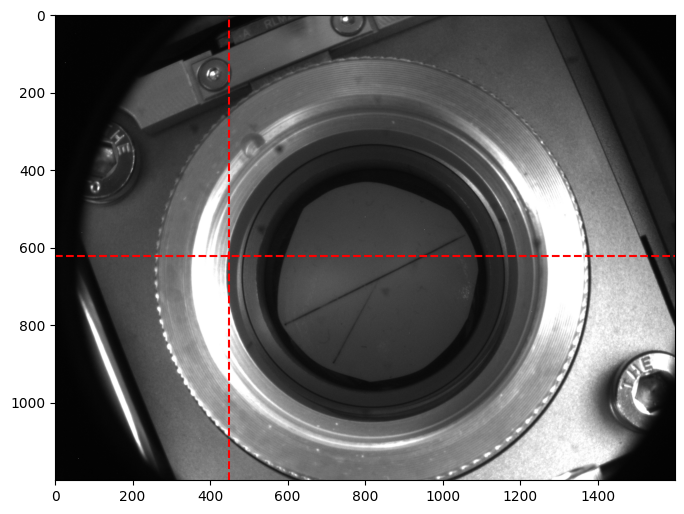

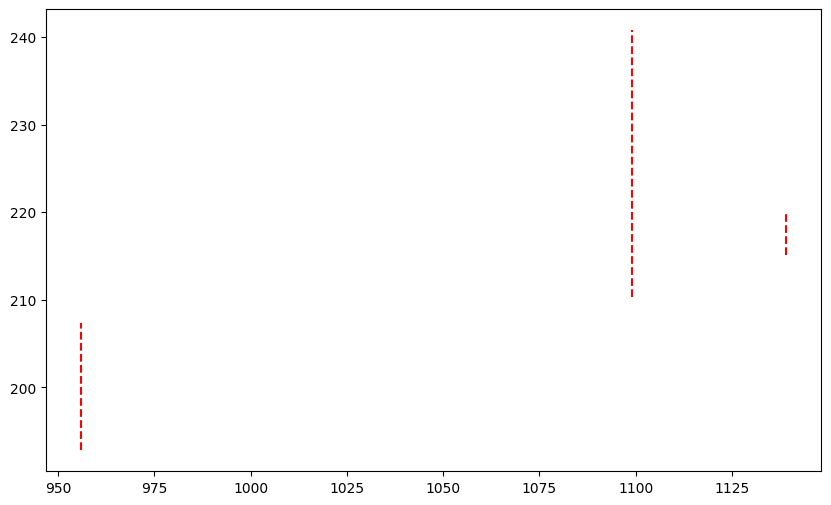

In [6]:
#for testing grab one horizotanl and one vertical cross seciton of the image
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
random_x = 350
random_y = 400

the_peaks = []

import random
for i in np.arange(75):
    
    horizontal_good_peak = []   
    vertical_good_peak = []
    vertical_selected_peak = []
    hotizontal_selected_peak=[]


    random_x+=10
    random_y+=10
    random_y=620


    if random_y < Vertical_limits[0] or random_x > Vertical_limits[1]:
        random_y = 400
    if random_x < Horizontal_limits[0] or random_y > Horizontal_limits[1]:
        random_x = 450


    # random_x = random.randint(Vertical_limits[0]+200, Vertical_limits[1]-150)
    # random_y = random.randint(Horizontal_limits[0]+100, Horizontal_limits[1]-100)

    # random_x = 710
    # random_y = 610

    fig1, ax1 = plt.subplots(figsize=(8, 8))
    ax1.imshow(image_rgb)
    ax1.axvline(x=random_x, color='red', linestyle='--')
    ax1.axhline(y=random_y, color='red', linestyle='--')

    fig, ax = plt.subplots(1,1,figsize=(10, 6))

    fig_extra = [ax,0]#,ax[0]]
    ax = fig_extra
    print(f"Random Y: {random_y}, Random X: {random_x}")

    horizontal_cross_section = gray_image[random_y,:].copy()
    vertical_cross_Section = gray_image[:,random_x].copy()
    image_height_px, image_width_px, _ = image_rgb.shape

    #flip the the data to highlight darker points
    horizontal_cross_section = np.max(horizontal_cross_section) - horizontal_cross_section
    vertical_cross_Section = np.max(vertical_cross_Section) - vertical_cross_Section
    untrimmed_horizontal = horizontal_cross_section
    untrimmed_vertical = vertical_cross_Section

    #clean up the edges, outside of the limits
    horizontal_cross_section[:Horizontal_limits[0]-100] = horizontal_cross_section[Horizontal_limits[0]-100]
    horizontal_cross_section[Horizontal_limits[1]+100:] = horizontal_cross_section[Horizontal_limits[1]+100]
    vertical_cross_Section[:Vertical_limits[0]-100] = vertical_cross_Section[Vertical_limits[0]-100]
    vertical_cross_Section[Vertical_limits[1]+100:] = vertical_cross_Section[Vertical_limits[1]+100]


    raw_horizontal = horizontal_cross_section.copy()
    raw_vertical   = vertical_cross_Section.copy()
    smooth_horizontal = scipy.signal.savgol_filter(horizontal_cross_section, window_length=50, polyorder=3)
    smooth_vertical   = scipy.signal.savgol_filter(vertical_cross_Section, window_length=50, polyorder=3)
    #light smoothing with a savitzky golay filter
    horizontal_cross_section = scipy.signal.savgol_filter(horizontal_cross_section, window_length=15, polyorder=3)
    vertical_cross_Section = scipy.signal.savgol_filter(vertical_cross_Section, window_length=15, polyorder=3)

    hor_plat_smooth = scipy.signal.savgol_filter(raw_horizontal, window_length=50, polyorder=7)
    ver_plat_smooth = scipy.signal.savgol_filter(raw_vertical, window_length=50, polyorder=7)
    if 1:
        #Finding horizontal plateus
        try:
            left_plateu, left_plateu_properties = find_first_plateu(horizontal_cross_section,min_plateu_width=[1,320], threshold=35,bounds=Horizontal_limits,center = image_width_px//2)
            print(f"Left plateu at: {left_plateu}")
            #left_plateu_right_base = left_plateu_properties['right_edges'] if left_plateu_properties is not None else None
            if left_plateu > image_width_px//2 or left_plateu < Horizontal_limits[0]:
                print("Left plateu out of bounds, ignoring")
                left_plateu = None
                left_plateu_properties = None
            
        except Exception as e:
            print("Error finding left plateu:", e)
            left_plateu = None
            left_plateu_properties = None

        try:
            right_plateu, right_plateu_properties = find_second_plateu(horizontal_cross_section,min_plateu_width=[1,320], threshold=35,bounds=Horizontal_limits,center = image_width_px//2)
            print(f"Right plateu at: {right_plateu}")
            if right_plateu < image_width_px//2 or right_plateu > Horizontal_limits[1]:
                print("Right plateu out of bounds, ignoring")
                right_plateu = None
                right_plateu_properties = None
        except Exception as e:
            print("Error finding right plateu:", e)
            right_plateu = None
            right_plateu_properties = None
        try:
            horiztonal_plateus = find_plateus(horizontal_cross_section, min_plateu_width=[1,320], threshold=30,bounds=Horizontal_limits)
        except Exception as e:
            print("Error finding horizontal plateus:", e)
            horiztonal_plateus = None


        #finding a if there is a good peak in horizontal
        try:
            horizontal_good_peak, horizontal_good_peaks_properties = find_best_peak(smooth_horizontal,#horizontal_cross_section,
                                                                                threshold = [3.3,100],
                                                                                width = [4,50],
                                                                                bounds=[left_plateu+25,right_plateu-25])


            ax[0].vlines(x=horizontal_good_peak, ymin = smooth_horizontal[horizontal_good_peak]-horizontal_good_peaks_properties['prominences'],
                        ymax = smooth_horizontal[horizontal_good_peak], color='red', linestyle='--', label='Good Peaks')




            all_peaks, all_props = find_best_peak(raw_horizontal, threshold=[1,100],
                                            width=[1,100],
                                            bounds= [left_plateu+15,right_plateu-15])
            

            #check good_peaks agains plateus

            



        except Exception as e:
            print("Error", e)

        # print("good peaks")
        # print(horizontal_good_peak)
        # for key in horizontal_good_peaks_properties.keys():
        #     print(f"{key}, {horizontal_good_peaks_properties[key]}")

        # print(f"all peaks \n{all_peaks}")
        # for key in all_props.keys():
        #     print(key, all_props[key])


        # for key in horizontal_good_peaks_properties:
        #     print(f"{key}, {horizontal_good_peaks_properties[key]}")
            #only best two peaks from vertical_good_peaks 
        if horizontal_good_peak is not None:
            if len(horizontal_good_peak) > 2:
                sorted_indices = np.argsort(horizontal_good_peaks_properties['prominences'])[::-1]
                top_two_indices = sorted_indices[:2]
                horizontal_selected_peak = horizontal_good_peak[top_two_indices]
                horizontal_selected_peaks_properties = {key: np.array(value)[top_two_indices] for key, value in horizontal_good_peaks_properties.items()}
            else:
                horizontal_selected_peak = horizontal_good_peak
                horizontal_selected_peaks_properties = horizontal_good_peaks_properties

        #drop peak if outside of pleatus 
        


        print("\n\n")

    if 0:
        #Finding vertical plateus
        try:
            top_plateu, top_plateu_properties = find_first_plateu(ver_plat_smooth,  
                                                                min_plateu_width=[20,200],
                                                                threshold=20,
                                                                bounds=Vertical_limits,
                                                                center = image_height_px//2)
            
            if top_plateu > image_height_px//2 or top_plateu < Vertical_limits[0]:
                print("Top plateu out of bounds, ignoring")
                top_plateu = None
            else:
                print(f"Top plateu at: {top_plateu}")
        except Exception as e:
            print("Error finding top plateus:", e)
            top_plateu = None


        try:
            bottom_plateu, bottom_plateu_properties = find_second_plateu(vertical_cross_Section, 
                                                                        min_plateu_width=[20,200],
                                                                        threshold=20,
                                                                        bounds=Vertical_limits,
                                                                        center = image_height_px//2)
            
            if bottom_plateu < image_height_px//2 or bottom_plateu > Vertical_limits[1]:
                print("bottom plateu out of bounds, ignoring")
                bottom_plateu = None
            else:
                print(f"bottom plateu at: {bottom_plateu}")
        except Exception as e:
            print("Error finding bottom plateus:", e)
            bottom_plateu = None

        # if top_plateu is  None or bottom_plateu is None:
        #     print("One of the vertical plateus is None, skipping vertical peak finding")
        #     break
        # if  np.abs(top_plateu - bottom_plateu) < 75:
        #     print("Vertical plateus too close together, skipping vertical peak finding")
        #     break

        try:
            vertical_plateus = find_plateus(vertical_cross_Section  ,
                                            min_plateu_width=[1,520], 
                                            threshold=10,
                                            bounds=Vertical_limits)

            ax[1].vlines(x=vertical_plateus[0], ymin = vertical_cross_Section[vertical_plateus[0]]-vertical_plateus[1]['prominences'],
                        ymax = vertical_cross_Section[vertical_plateus[0]], color='magenta', linestyle='--', label='Plateus')


            # print("Vertical plateus found:", vertical_plateus)
            # for key in vertical_plateus[1].keys():
            #     print(f"  {key}: {vertical_plateus[1][key]}")

            #check the separation of the peak and ips
            for i, peak in enumerate(vertical_plateus[0]):
                left_base = vertical_plateus[1]['left_bases'][i]
                right_base = vertical_plateus[1]['right_bases'][i]
                left_ips = vertical_plateus[1]['left_ips'][i]
                right_ips = vertical_plateus[1]['right_ips'][i]
                #print(f"Peak {peak}: left_base={left_base}, right_base={right_base}, left_ips={left_ips}, right_ips={right_ips}")
                ax[1].hlines(y=vertical_cross_Section[left_base], xmin=left_base, xmax=peak, color='green', linestyle='--', label='Left Base')
                ax[1].hlines(y=vertical_cross_Section[right_base], xmin=peak, xmax=right_base, color='orange', linestyle='--', label='Right Base')
                ax[1].hlines(y=vertical_cross_Section[int(left_ips)], xmin=left_ips, xmax=peak, color='purple', linestyle='--', label='Left IPS')
                ax[1].hlines(y=vertical_cross_Section[int(right_ips)], xmin=peak, xmax=right_ips, color='brown', linestyle='--', label='Right IPS')
                # threshild from both ips
                left_threshold = vertical_cross_Section[vertical_plateus[0][i]] - vertical_cross_Section[int(left_ips)]
                right_threshold = vertical_cross_Section[vertical_plateus[0][i]] - vertical_cross_Section[int(right_ips)]

                #print(f"  Thresholds: left={left_threshold}, right={right_threshold}")




        except Exception as e:
            print("Error finding vertical plateus:", e)
            vertical_plateus = None



        #finding a if there is a good peak in vertical
        try:
            vertical_good_peak, vertical_good_peaks_properties = find_best_peak(vertical_cross_Section,
                                                                                threshold = [15,100],
                                                                                width = [5,50],
                                                                                height=10,
                                                                                bounds=[top_plateu+5,bottom_plateu-5])
            

            v_all_peaks, v_all_props = find_best_peak(vertical_cross_Section, 
                                            threshold=[1,100],
                                            width=[1,100],
                                            height=10,
                                            bounds= [top_plateu+15,bottom_plateu-15])

            ax[1].vlines(x=vertical_good_peak, ymin = smooth_vertical[vertical_good_peak]-vertical_good_peaks_properties['prominences'],
                        ymax = smooth_vertical[vertical_good_peak], color='red', linestyle='--', label='Good Peaks')

            ax[1].vlines(x=v_all_peaks, ymin = smooth_vertical[v_all_peaks]-v_all_props['prominences'],
                        ymax = smooth_vertical[v_all_peaks], color='blue', linestyle='--', label='All Peaks')


            #only best two peaks from vertical_good_peaks 
            if vertical_good_peak is not None:
                if len(vertical_good_peak) > 2:
                    sorted_indices = np.argsort(vertical_good_peaks_properties['prominences'])[::-1]
                    top_two_indices = sorted_indices[:2]
                    vertical_selected_peak = vertical_good_peak[top_two_indices]
                    vertical_selected_peaks_properties = {key: np.array(value)[top_two_indices] for key, value in vertical_good_peaks_properties.items()}
                else:
                    vertical_selected_peak = vertical_good_peak
                    vertical_selected_peaks_properties = vertical_good_peaks_properties

        except Exception as e:
            print("Error finding vertical good peak:", e)
            vertical_good_peak = []
            vertical_good_peaks_properties = {}
            v_all_peaks = []
            v_all_props = {}

        # print("good peaks")
        # print(vertical_good_peak)
        # for key in vertical_good_peaks_properties:
        #     print(f"{key}, {vertical_good_peaks_properties[key]}")

        # print("all peaks \n", v_all_peaks)
        # for key in v_all_props.keys():
        #     print(key, v_all_props[key])

    right_plateu=1100
    left_plateu=511

    good_hor_platues = right_plateu is not None and left_plateu is not None
    good_vertical_platues = top_plateu != None and bottom_plateu is not None
    #make sure vertical points are in horixontal bounds

    if good_hor_platues :
        if random_x <left_plateu or random_x > right_plateu:
            print("vertical point is outside of bounds")
            print(f" lower limit {left_plateu}, upper limit {right_plateu}, value {random_x}")
            vertical_good_peak=[]
            vertical_good_peaks_properties=[]
    if good_vertical_platues:
        #make sure horizontal points are in vertical bounds
        if random_y <top_plateu or random_y > bottom_plateu:
            print("horizontal point is outside of bounds")
            print(f" lower limit {top_plateu}, upper limit {bottom_plateu}, value {random_y}")
            horizontal_good_peak=[]
            horizontal_good_peaks_properties=[]
        
    if len(horizontal_good_peak) == 0:
        print("No good horizontal peak found")
    else:
        for peak in horizontal_good_peak:
            ax1.errorbar( x=peak,y=random_y,marker="x")
    if len(vertical_good_peak) == 0:
        print("No good vertical peak found")
    else:
        for peak in vertical_selected_peak:
            ax1.errorbar(y=peak,x=random_x,fmt="",marker="x")
    if len(horizontal_good_peak) ==0 and len(vertical_good_peak) ==0:
        print("No good peaks found in both horizontal and vertical directions")


    #plotting horizontal cross section
    if 1:
        # ax=[0,ax]
        ax[0].plot(horizontal_cross_section)
        ax[0].plot(untrimmed_horizontal,':',alpha=0.7)
        
        #ax[0].errorbar(x=np.arange(len(raw_horizontal)),y=raw_horizontal, fmt=":")
        ax[0].set_ylabel("Horizontal Cross Section")
        ax[0].grid()
        ax[0].text(0.95, 0.95, f'Y={random_y}px', transform=ax[0].transAxes, 
                fontsize=12, verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        if left_plateu is not None:
            ax[0].axvline(x=left_plateu, color='red', linestyle='--', label='Left Plateu')
            #ax[0].axvline(x=left_plateu_right_base, color='orange', linestyle='--', label='Left Plateu Right Base')
        if right_plateu is not None:
            ax[0].axvline(x=right_plateu, color='blue', linestyle='--', label='Right Plateu')
            #ax[0].axvline(x=right_plateu_properties['left_edges'], color='cyan', linestyle='--', label='Right Plateu Left Base')
        if horizontal_good_peak is not None:
            if len(horizontal_good_peak) >0:
            
                ax[0].plot(horizontal_good_peak,horizontal_good_peaks_properties["peak_heights"],'x',markersize=10)


        if horiztonal_plateus is not None:
            ax[0].plot(horiztonal_plateus[0], horiztonal_plateus[1]["peak_heights"], 'o', color='red', label='Plateus')

        #average horizontal cross section for entries between the two plateus
        avg_horizontal = np.mean(horizontal_cross_section[left_plateu:right_plateu])
        # print(f"Average horizontal cross section (above 0): {avg_horizontal:.2f}")

        ax[0].axhline(y=avg_horizontal, color='green', linestyle='--', label='Average (above 0)')

        ax[0].set_ylim(avg_horizontal-30, np.max(horizontal_cross_section))

    #plotting vertical cross section
    if 0:
        ax[1].plot(vertical_cross_Section, color="magenta")
        #ax[1].errorbar(x=np.arange(len(raw_vertical)),y=raw_vertical,fmt=":")
        ax[1].plot(untrimmed_vertical,':',alpha=1)
        #ax[1].plot(smooth_vertical,':',alpha=0.7)
        ax[1].plot(ver_plat_smooth,':',color="green",alpha=1)
        ax[1].set_ylabel("Vertical Cross Section")
        ax[1].grid()
        ax[1].text(0.95, 0.95, f'X={random_x}px', transform=ax[1].transAxes, 
                fontsize=12, verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        if top_plateu is not None:
            ax[1].axvline(x=top_plateu, color='red', linestyle='--', label='Top Plateu')

        if bottom_plateu is not None:
            ax[1].axvline(x=bottom_plateu, color='blue', linestyle='--', label='Bottom Plateu')

        if vertical_plateus is not None:
            ax[1].plot(vertical_plateus[0], vertical_plateus[1]["peak_heights"], 'o', color='red', label='Plateus')

        if len(vertical_good_peak) > 0:
            ax[1].plot(vertical_good_peak,vertical_good_peaks_properties["peak_heights"],'x',markersize=10)

        avg_vertical = np.mean(vertical_cross_Section[top_plateu:bottom_plateu])
        # print(f"Average vertical cross section (above 0): {avg_vertical:.2f}")


        ax[1].set_xlim(Vertical_limits[0], Vertical_limits[1])
        #ax[1].set_ylim(avg_vertical-50, avg_vertical+60)
        if len(vertical_selected_peak) >0:
            for sel_peak in vertical_selected_peak:
                if H_limit_hard[0] < random_x < H_limit_hard[1]:
                    if V_limit_hard[0] < sel_peak < V_limit_hard[1]:
                        the_peaks.append((random_x,sel_peak))

        if len(horizontal_selected_peak) >0:
            for sel_peak in horizontal_selected_peak:
                if H_limit_hard[0] < random_x < H_limit_hard[1]:
                    if V_limit_hard[0] < sel_peak < V_limit_hard[1]:
                        the_peaks.append((random_x,sel_peak))



        if i%5 !=0:
            plt.close(fig1)
            plt.close(fig)
            # plt.close(fig_extra)
    break

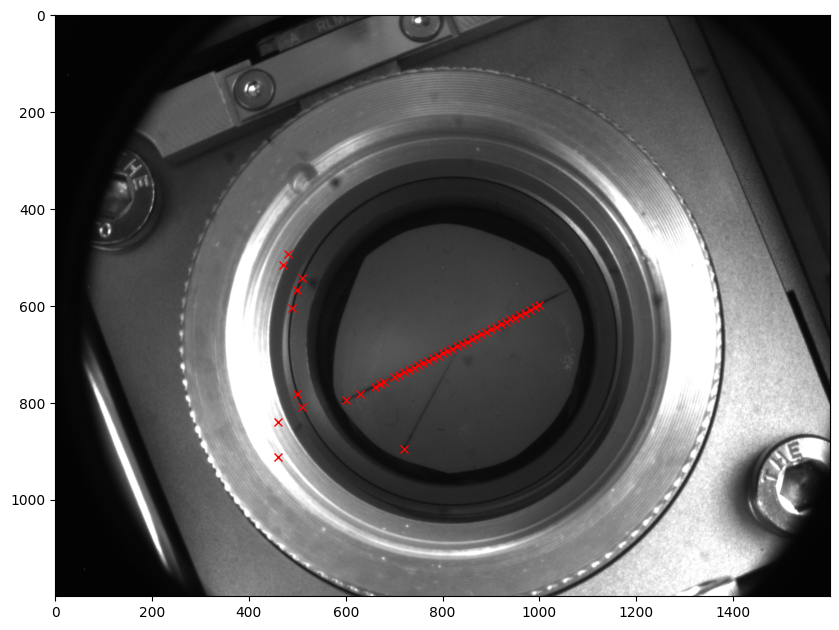

In [ ]:
the_peaks = np.array(the_peaks)
fig, ax = plt.subplots(figsize=(10,8))


ax.imshow(image_rgb)

ax.plot(the_peaks[:,0],the_peaks[:,1],marker="x",linestyle="None",color="red")

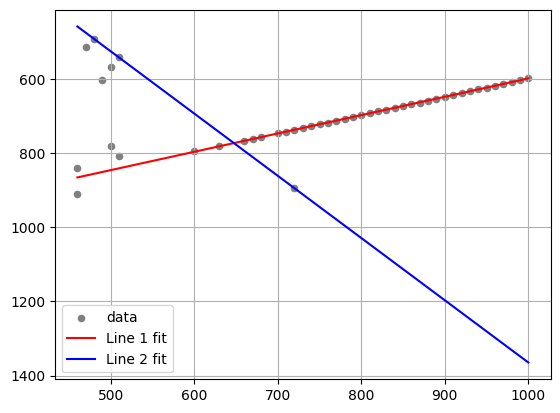

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RANSACRegressor, LinearRegression

points = the_peaks

X = points[:,0].reshape(-1,1)
y = points[:,1]

# Use RANSAC to detect first line
ransac1 = RANSACRegressor(LinearRegression(), residual_threshold=10, random_state=0)
ransac1.fit(X, y)
inlier_mask1 = ransac1.inlier_mask_

# Use RANSAC on remaining points for second line
X2 = X[~inlier_mask1]
y2 = y[~inlier_mask1]
ransac2 = RANSACRegressor(LinearRegression(), residual_threshold=10, random_state=1)
ransac2.fit(X2, y2)
inlier_mask2 = ransac2.inlier_mask_

fig, ax  = plt.subplots()
# Plot
plt.scatter(X, y, color="gray", s=20, label="data")
line_X = np.linspace(X.min(), X.max(), 500).reshape(-1,1)
plt.plot(line_X, ransac1.predict(line_X), "r-", label="Line 1 fit")
plt.plot(line_X, ransac2.predict(line_X), "b-", label="Line 2 fit")
#invert x axis
ax.yaxis.set_inverted(True)
plt.grid()
plt.legend()
plt.show()

In [ ]:
def fit_two_lines_ransac_improved(points, residual_threshold=10.0, min_angle_deg=15.0, 
                                 max_residual_score=0.5, min_inliers_ratio=0.1, 
                                 max_attempts=50, plot=True, verbose=True):
    """
    Fit two lines to point data using RANSACRegressor with LinearRegression.
    Validates angle separation and residual quality for robust fitting.
    
    Parameters:
    -----------
    points : array-like, shape (n_points, 2)
        x, y coordinates of points
    residual_threshold : float, default=10.0
        Maximum distance from line to be considered inlier
    min_angle_deg : float, default=15.0
        Minimum angle difference between lines in degrees
    max_residual_score : float, default=0.5
        Maximum allowed mean residual score (lower is better)
    min_inliers_ratio : float, default=0.3
        Minimum ratio of points that must be inliers for each line
    max_attempts : int, default=50
        Maximum number of random state attempts to find good fit
    plot : bool, default=True
        Whether to plot the results
    verbose : bool, default=True
        Whether to print fitting progress
        
    Returns:
    --------
    result : dict
        Dictionary containing:
        - 'line1_params': (slope, intercept) for line 1
        - 'line2_params': (slope, intercept) for line 2
        - 'inliers1': boolean mask for line 1 inliers
        - 'inliers2': boolean mask for line 2 inliers
        - 'fit_quality': dict with quality metrics
        - 'success': bool indicating if criteria were met
    """
    
    points = np.array(points)
    if len(points) < 6:  # Need at least 3 points per line
        if verbose:
            print("Error: Need at least 6 points to fit two lines")
        return None
    
    X = points[:, 0].reshape(-1, 1)
    y = points[:, 1]
    min_angle_rad = np.deg2rad(min_angle_deg)
    min_inliers_per_line = int(len(points) * min_inliers_ratio)
    
    best_fit = None
    best_score = float('inf')
    
    if verbose:
        print(f"Attempting to fit two lines to {len(points)} points...")
        print(f"Criteria: min_angle≥{min_angle_deg}°, max_residual≤{max_residual_score}, min_inliers≥{min_inliers_per_line}")
    
    for attempt in range(max_attempts):
        try:
            # Fit first line using RANSAC
            ransac1 = RANSACRegressor(
                LinearRegression(), 
                residual_threshold=residual_threshold, 
                random_state=attempt,
                min_samples=2
            )
            ransac1.fit(X, y)
            inlier_mask1 = ransac1.inlier_mask_
            
            # Check if first line has enough inliers
            if np.sum(inlier_mask1) < min_inliers_per_line:
                continue
            
            # Fit second line to remaining points
            X_remaining = X[~inlier_mask1]
            y_remaining = y[~inlier_mask1]
            
            if len(X_remaining) < min_inliers_per_line:
                continue
                
            ransac2 = RANSACRegressor(
                LinearRegression(),
                residual_threshold=residual_threshold,
                random_state=attempt + 1,
                min_samples=2
            )
            ransac2.fit(X_remaining, y_remaining)
            inlier_mask2_subset = ransac2.inlier_mask_
            
            # Map second line inliers back to original indices
            inlier_mask2 = np.zeros(len(points), dtype=bool)
            remaining_indices = np.where(~inlier_mask1)[0]
            inlier_mask2[remaining_indices[inlier_mask2_subset]] = True
            
            # Check if second line has enough inliers
            if np.sum(inlier_mask2) < min_inliers_per_line:
                continue
            
            # Get line parameters
            line1_slope = ransac1.estimator_.coef_[0]
            line1_intercept = ransac1.estimator_.intercept_
            line2_slope = ransac2.estimator_.coef_[0]
            line2_intercept = ransac2.estimator_.intercept_
            
            # Calculate angle between lines
            angle1 = np.arctan(line1_slope)
            angle2 = np.arctan(line2_slope)
            angle_diff = abs(angle1 - angle2)
            
            # Handle angle wraparound
            if angle_diff > np.pi/2:
                angle_diff = np.pi - angle_diff
            
            # Check angle criterion
            if angle_diff < min_angle_rad:
                continue
            
            # Calculate residual quality for both lines
            y_pred1 = line1_slope * X.flatten() + line1_intercept
            y_pred2 = line2_slope * X.flatten() + line2_intercept
            
            # Calculate residuals for inliers only
            residuals1 = np.abs(y[inlier_mask1] - y_pred1[inlier_mask1])
            residuals2 = np.abs(y[inlier_mask2] - y_pred2[inlier_mask2])
            
            mean_residual1 = np.mean(residuals1)
            mean_residual2 = np.mean(residuals2)
            overall_residual = (mean_residual1 + mean_residual2) / 2
            
            # Check residual criterion
            if overall_residual > max_residual_score * residual_threshold:
                continue
            
            # Calculate fit quality score (lower is better)
            angle_score = 1.0 / (1.0 + angle_diff)  # Prefer larger angles
            residual_score = overall_residual / residual_threshold
            coverage_score = 1.0 - (np.sum(inlier_mask1) + np.sum(inlier_mask2)) / len(points)
            
            total_score = angle_score + residual_score + coverage_score
            
            if total_score < best_score:
                best_score = total_score
                best_fit = {
                    'line1_params': (line1_slope, line1_intercept),
                    'line2_params': (line2_slope, line2_intercept),
                    'inliers1': inlier_mask1.copy(),
                    'inliers2': inlier_mask2.copy(),
                    'fit_quality': {
                        'angle_diff_deg': np.rad2deg(angle_diff),
                        'mean_residual1': mean_residual1,
                        'mean_residual2': mean_residual2,
                        'overall_residual': overall_residual,
                        'inliers1_count': np.sum(inlier_mask1),
                        'inliers2_count': np.sum(inlier_mask2),
                        'outliers_count': len(points) - np.sum(inlier_mask1) - np.sum(inlier_mask2),
                        'coverage_ratio': (np.sum(inlier_mask1) + np.sum(inlier_mask2)) / len(points),
                        'quality_score': total_score
                    },
                    'success': True,
                    'ransac1': ransac1,
                    'ransac2': ransac2
                }
                
                if verbose and attempt % 10 == 0:
                    print(f"Attempt {attempt}: angle={np.rad2deg(angle_diff):.1f}°, "
                          f"residual={overall_residual:.2f}, score={total_score:.3f}")
        
        except Exception as e:
            if verbose and attempt % 20 == 0:
                print(f"Attempt {attempt} failed: {e}")
            continue
    
    if best_fit is None:
        if verbose:
            print("❌ Failed to find lines meeting all criteria")
        return {
            'line1_params': None,
            'line2_params': None,
            'inliers1': None,
            'inliers2': None,
            'fit_quality': None,
            'success': False
        }
    
    # Print results
    if verbose:
        print(f"\n✅ Successfully found two lines after {max_attempts} attempts:")
        print(f"Line 1: y = {best_fit['line1_params'][0]:.3f}x + {best_fit['line1_params'][1]:.3f}")
        print(f"Line 2: y = {best_fit['line2_params'][0]:.3f}x + {best_fit['line2_params'][1]:.3f}")
        print(f"Angle difference: {best_fit['fit_quality']['angle_diff_deg']:.1f}°")
        print(f"Mean residuals: {best_fit['fit_quality']['mean_residual1']:.2f}, {best_fit['fit_quality']['mean_residual2']:.2f}")
        print(f"Coverage: {best_fit['fit_quality']['coverage_ratio']:.1%}")
        print(f"Inliers: {best_fit['fit_quality']['inliers1_count']} + {best_fit['fit_quality']['inliers2_count']} = {best_fit['fit_quality']['inliers1_count'] + best_fit['fit_quality']['inliers2_count']}")
        print(f"Outliers: {best_fit['fit_quality']['outliers_count']}")
    
    # Plot results
    if plot:
        plt.figure(figsize=(12, 8))
        
        # Plot all points
        plt.scatter(points[:, 0], points[:, 1], c='lightgray', alpha=0.6, s=30, label='All points')
        
        # Plot inliers for each line
        inliers1 = best_fit['inliers1']
        inliers2 = best_fit['inliers2']
        
        if np.any(inliers1):
            plt.scatter(points[inliers1, 0], points[inliers1, 1], 
                       c='red', s=50, alpha=0.8, label=f'Line 1 inliers ({np.sum(inliers1)})')
        
        if np.any(inliers2):
            plt.scatter(points[inliers2, 0], points[inliers2, 1], 
                       c='blue', s=50, alpha=0.8, label=f'Line 2 inliers ({np.sum(inliers2)})')
        
        # Plot outliers
        outliers = ~(inliers1 | inliers2)
        if np.any(outliers):
            plt.scatter(points[outliers, 0], points[outliers, 1], 
                       c='black', marker='x', s=60, label=f'Outliers ({np.sum(outliers)})')
        
        # Plot fitted lines
        x_range = np.linspace(points[:, 0].min() - 10, points[:, 0].max() + 10, 100)

        #line two ends at line 1. 
        x_range_line2 = np.linespace
        
        line1_slope, line1_intercept = best_fit['line1_params']
        line2_slope, line2_intercept = best_fit['line2_params']
        
        y_line1 = line1_slope * x_range + line1_intercept
        y_line2 = line2_slope * x_range + line2_intercept
        
        angle1_deg = np.rad2deg(np.arctan(line1_slope))
        angle2_deg = np.rad2deg(np.arctan(line2_slope))
        
        plt.plot(x_range, y_line1, 'r--', linewidth=3, alpha=0.8,
                label=f'Line 1: y={line1_slope:.3f}x+{line1_intercept:.1f} (θ={angle1_deg:.1f}°)')
        plt.plot(x_range, y_line2, 'b--', linewidth=3, alpha=0.8,
                label=f'Line 2: y={line2_slope:.3f}x+{line2_intercept:.1f} (θ={angle2_deg:.1f}°)')
        
        plt.xlabel('X coordinate')
        plt.ylabel('Y coordinate')
        plt.title(f'RANSAC Two-Line Fitting (Angle diff: {best_fit["fit_quality"]["angle_diff_deg"]:.1f}°, '
                  f'Coverage: {best_fit["fit_quality"]["coverage_ratio"]:.1%})')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    return best_fit

In [ ]:
# Test the improved RANSAC function with your peak data
if len(the_peaks) > 0:
    print(f"Testing improved RANSAC function with {len(the_peaks)} peaks...")
    
    # Test with different parameter sets
    test_configs = [
        {'residual_threshold': 18.0, 'min_angle_deg': 15.0, 'max_residual_score': 1.4},
        {'residual_threshold': 20.0, 'min_angle_deg': 20.0, 'max_residual_score': 1.5},
        {'residual_threshold': 22.0, 'min_angle_deg': 25.0, 'max_residual_score': 1.6}
    ]
    
    best_result = None
    best_coverage = 0
    
    for i, config in enumerate(test_configs):
        print(f"\n{'='*60}")
        print(f"Configuration {i+1}: {config}")
        print('='*60)
        
        result = fit_two_lines_ransac_improved(
            the_peaks, 
            residual_threshold=config['residual_threshold'],
            min_angle_deg=config['min_angle_deg'],
            max_residual_score=config['max_residual_score'],
            max_attempts=30,
            plot=True,
            verbose=True
        )
        
        if result and result['success']:
            coverage = result['fit_quality']['coverage_ratio']
            if coverage > best_coverage:
                best_coverage = coverage
                best_result = result
                best_config = config
    
    if best_result:
        print(f"\n{'🏆 BEST RESULT ':-^60}")
        print(f"Best configuration: {best_config}")
        print(f"Coverage: {best_result['fit_quality']['coverage_ratio']:.1%}")
        print(f"Angle separation: {best_result['fit_quality']['angle_diff_deg']:.1f}°")
        print(f"Quality metrics:")
        for key, value in best_result['fit_quality'].items():
            if isinstance(value, (int, float)):
                print(f"  {key}: {value:.3f}")
            else:
                print(f"  {key}: {value}")
    else:
        print("\n❌ None of the configurations produced a successful fit")
        print("Try adjusting parameters:")
        print("  - Increase residual_threshold for more tolerance")
        print("  - Decrease min_angle_deg for less strict angle requirements")
        print("  - Increase max_residual_score for more lenient residual acceptance")
        
else:
    print("No peak data available. Please run the peak detection code first.")

Testing improved RANSAC function with 46 peaks...

Configuration 1: {'residual_threshold': 18.0, 'min_angle_deg': 15.0, 'max_residual_score': 1.4}
Attempting to fit two lines to 46 points...
Criteria: min_angle≥15.0°, max_residual≤1.4, min_inliers≥4
❌ Failed to find lines meeting all criteria

Configuration 2: {'residual_threshold': 20.0, 'min_angle_deg': 20.0, 'max_residual_score': 1.5}
Attempting to fit two lines to 46 points...
Criteria: min_angle≥20.0°, max_residual≤1.5, min_inliers≥4
❌ Failed to find lines meeting all criteria

Configuration 2: {'residual_threshold': 20.0, 'min_angle_deg': 20.0, 'max_residual_score': 1.5}
Attempting to fit two lines to 46 points...
Criteria: min_angle≥20.0°, max_residual≤1.5, min_inliers≥4
❌ Failed to find lines meeting all criteria

Configuration 3: {'residual_threshold': 22.0, 'min_angle_deg': 25.0, 'max_residual_score': 1.6}
Attempting to fit two lines to 46 points...
Criteria: min_angle≥25.0°, max_residual≤1.6, min_inliers≥4
❌ Failed to find l

In [ ]:
fit_two_lines_ransac_improved(the_peaks,max_residual_score=10)

Attempting to fit two lines to 46 points...
Criteria: min_angle≥15.0°, max_residual≤10, min_inliers≥4
❌ Failed to find lines meeting all criteria
❌ Failed to find lines meeting all criteria


{'line1_params': None,
 'line2_params': None,
 'inliers1': None,
 'inliers2': None,
 'fit_quality': None,
 'success': False}

In [ ]:

lines = fit_two_lines_ransac_improved(the_peaks,verbose=0,plot=False)

In [ ]:
#use find the angle between the left horixtonal and line 1 using line 2 as way to determine the topside of line 1.
line_1 = lines["line1_params"]

angles_line1 = np.arctan(line1_params[0]) *(180/np.pi)


print(angles_line1)

-26.596267777013725
